<div
      style="
        text-align: center;
        font-weight: bold;
        font-size: 32px;
        font-family: Arial, Helvetica, sans-serif;
        color: white;
        background-color: rgb(110, 95, 84);
        padding-top: 20px;
        padding-bottom: 20px;
        border-radius: 20px;
      "
    >
      CMI | Problematic Internet Use
    </div>

# Team information: Zenith³
*  Mai Anh Tuan - 22028144
* Luong Thi Linh - 22028202
* Nguyen Thi Thu Trang - 22028254 

# I. Import Library

In [1]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [2]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetRegressor

from colorama import Fore, Style
from IPython.display import clear_output
import warnings

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [3]:
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(2024)

In [4]:
SEED = 42
n_splits = 5

# II. Data Exploration


## 1. Data Preview

In [5]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col='id')
test= pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [6]:
display(train.head())
print(f"Train shape: {train.shape}")

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 81)


In [7]:
display(test.head())
print(f"Test shape: {test.shape}")

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test shape: (20, 58)


In [8]:
display(data_dict.head())
print(f"Dictionary shape: {data_dict.shape}")

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


Dictionary shape: (81, 6)


## 2. Missing values and Target variables

Duplicates in data train: 137
Duplicates in data test: 0
Percentage of null values in each column in train dataset
Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
                                            ...    
SDS-SDS_Total_Raw                         34.116162
SDS-SDS_Total_T                           34.191919
PreInt_EduHx-Season                       10.606061
PreInt_EduHx-computerinternet_hoursday    16.641414
sii                                       30.909091
Length: 81, dtype: float64


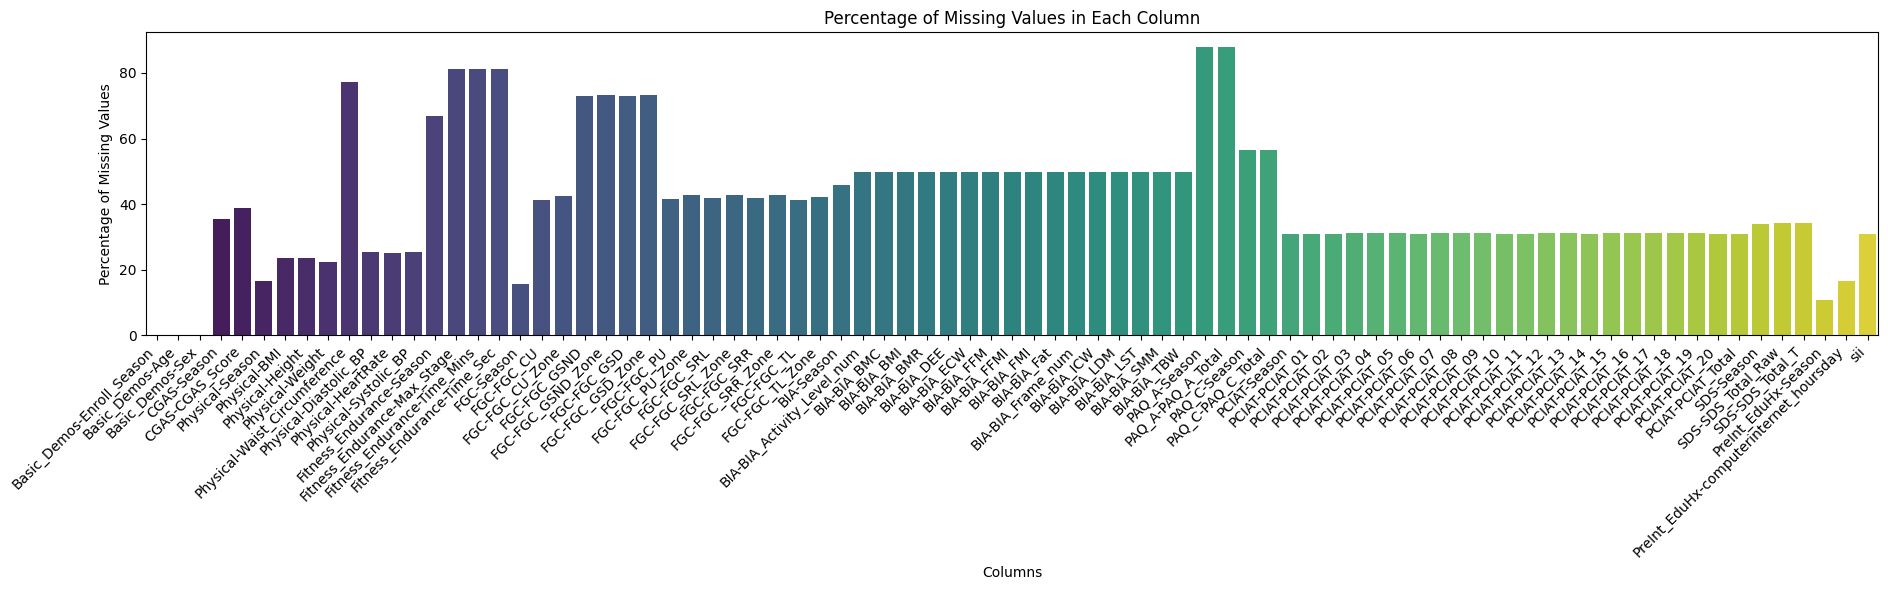

In [9]:
print('Duplicates in data train:', train.duplicated().sum())
print('Duplicates in data test:', test.duplicated().sum())

print('Percentage of null values in each column in train dataset')

print(train.isnull().mean() * 100)

missing_percentage = train.isnull().mean() * 100


plt.figure(figsize=(19, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.tight_layout()
plt.show()

Percentage of null values in each column in test dataset


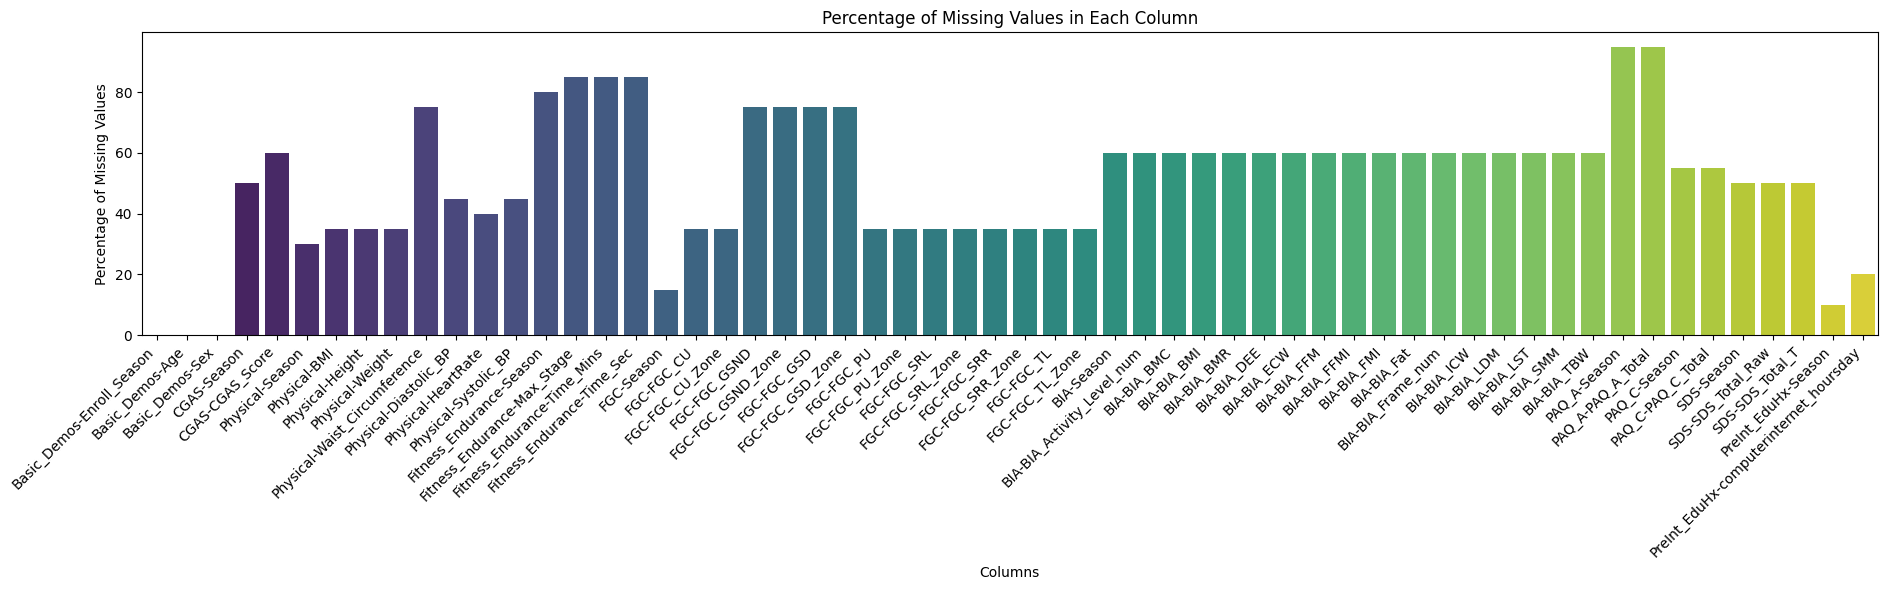

In [10]:
print('Percentage of null values in each column in test dataset')
test.isnull().mean() * 100

missing_percentage = test.isnull().mean() * 100


plt.figure(figsize=(19, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.tight_layout()
plt.show()

As we can see:

* There are duplicates data in train dataset
* On both train and test data, columns revelant to Season have high missing percentage, so we can drop these columns.

In [11]:
train_cols = set(train.columns)
test_cols = set(test.columns)
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])
columns_not_in_test = sorted(list(train_cols - test_cols)) 
data_dict[data_dict['Field'].isin(columns_not_in_test)]

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


We also have season of participation in PCIAT-Season and total Score in PCIAT-PCIAT_Total; so there are 22 PCIAT test-related columns in total.

In [12]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max', 'count'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum PCIAT total Score', 'count': 'Count' }
)
pciat_min_max

,Minimum PCIAT total Score,Maximum PCIAT total Score,Count
sii,,,
0.0,0.0,30.0,1594
1.0,31.0,49.0,730
2.0,50.0,79.0,378
3.0,80.0,93.0,34


In [13]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

## 3. Check missing answers

The SII score is still derived from the the sum of the non-NA values, leading to potentially invalid SII values.

In [14]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
id,,,,,,,,,,,,,,,,,,,,,,,
011e71c3,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
053d7d31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
05bc318e,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
08159c5e,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
082df556,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


Let's check if PCIAT-PCIAT_Total was indeed calculated as a sum of non-NA values in PCIAT-PCIAT_01 to PCIAT-PCIAT_20 columns

In [15]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-PCIAT_Total']).all()

True

For now, we can conclude that the SII score is sometimes incorrect. Below I recalculate the SII based on PCIAT_Total and the maximum possible score if missing values were answered (5 points), ensuring that the recalculated SII meets the intended thresholds even with some missing answers.

In [16]:
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

In [17]:
# Verification of rows with different original and recalculated SII:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
id,,,,,,,,,,,,,,,,,,,,,,,
011e71c3,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
053d7d31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
05bc318e,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
08159c5e,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
082df556,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
0fbb3ca5,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
1551c806,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
23418fa2,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
2bad0db7,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan


17 rows the target variable was calculated incorrectly (ignoring missing responses).

## 4. Distribution of SII & PCIAT_Total

In [18]:
train['sii'] = train['recalc_sii']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train.drop(columns='recalc_sii', inplace=True)

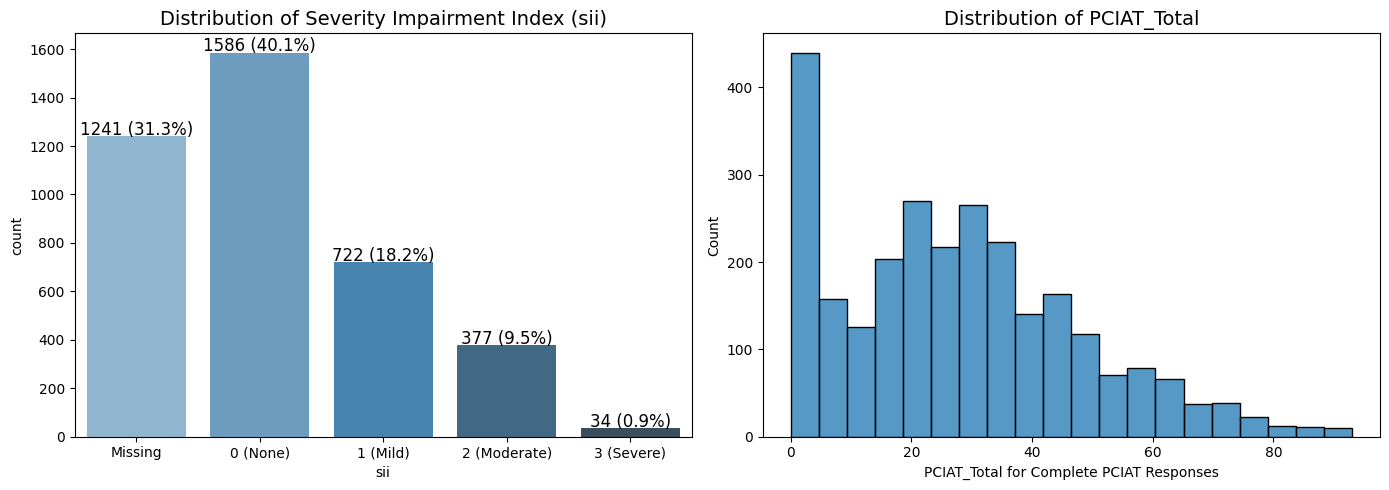

In [19]:
sii_counts = train['sii'].value_counts().reset_index()
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

In [20]:
len(train[train['complete_resp_total'] == 0])

307

Apparently, 40% of the participants were not affected by Internet use, 31% were not assessed, and only the minority (~10%) are moderately to severely impaired. There are 307 participants who scored 0 on all PCIAT questions.

## 5. Distribution for each Age Group

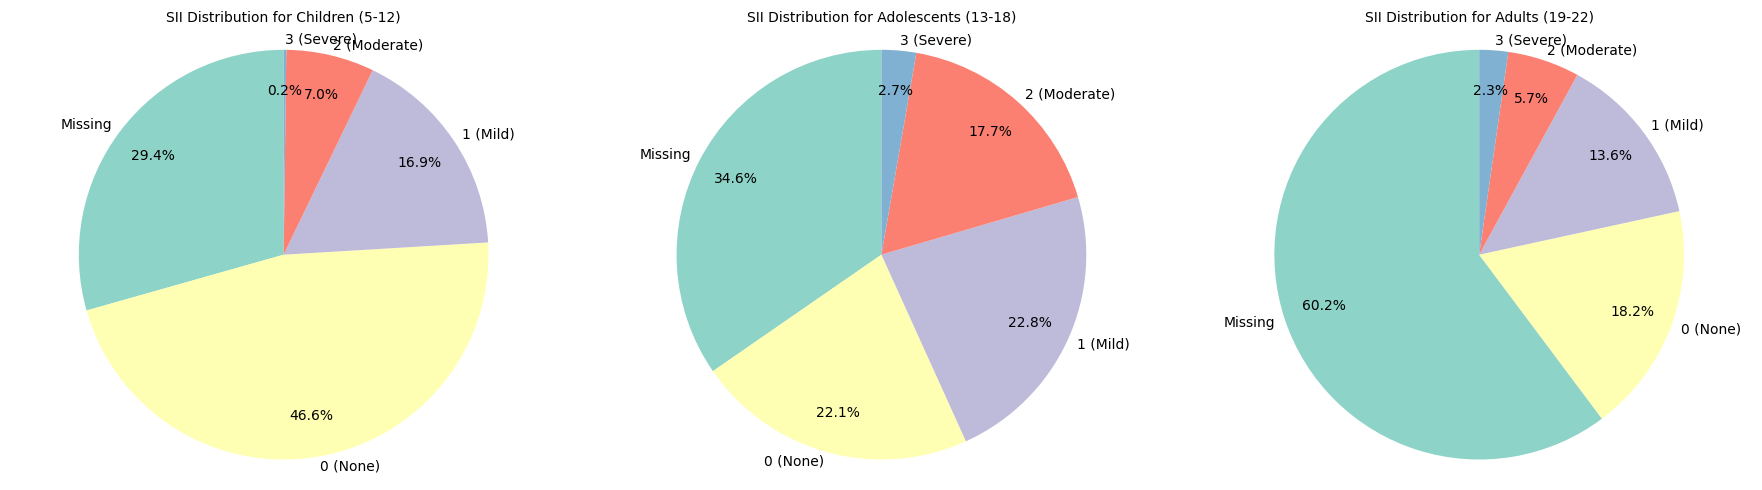

In [21]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)

stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

valid_age_groups = [age_group for age_group in stats.index if stats.loc[age_group].sum() > 0]

for i, age_group in enumerate(valid_age_groups):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}', fontsize=10)
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

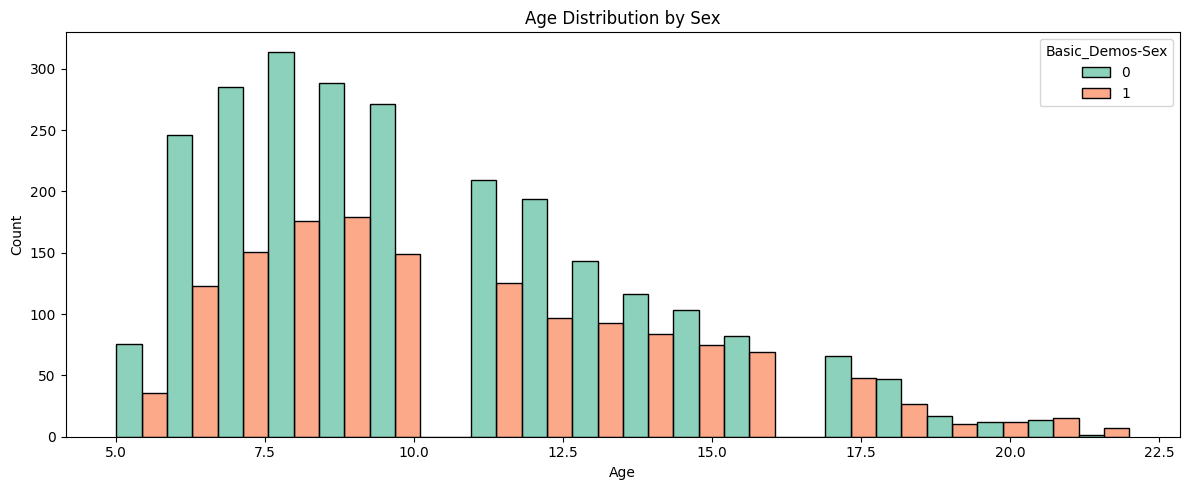

In [22]:
fig, axes = plt.subplots(1, figsize=(12, 5))

# Age Distribution by Sex
sns.histplot(
    data=train, x='Basic_Demos-Age',
    hue='Basic_Demos-Sex', multiple='dodge',
    palette="Set2", bins=20, ax=axes
)
axes.set_title('Age Distribution by Sex')
axes.set_xlabel('Age')
axes.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 6. Season Distribution

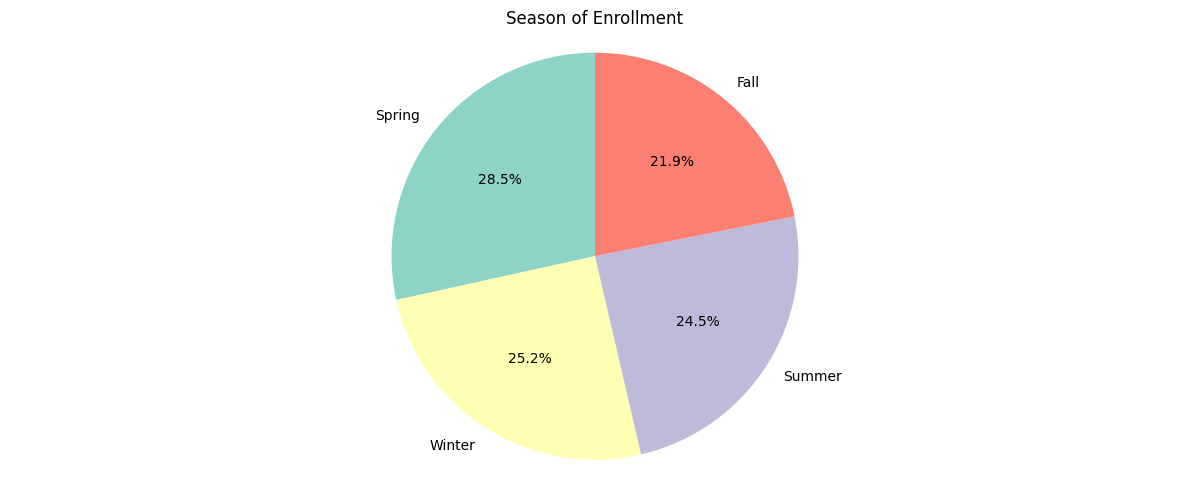

In [23]:
fig, axes = plt.subplots(1,figsize=(12, 5))

season_counts = train['Basic_Demos-Enroll_Season'].value_counts(dropna=False)

axes.pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes.set_title('Season of Enrollment')
axes.axis('equal')
plt.tight_layout()
plt.show()

## 7. Internet Usage

In [24]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

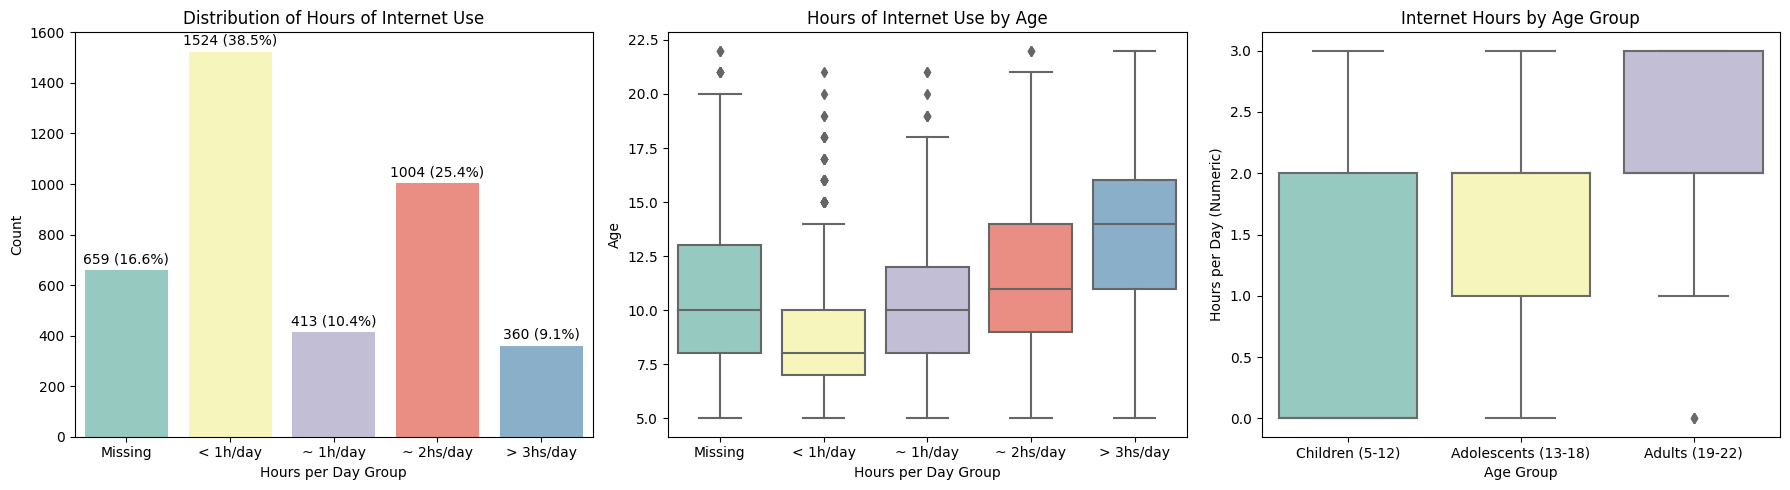

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hours of Internet Use
ax1 = sns.countplot(x='internet_use_encoded', data=train, palette="Set3", ax=axes[0])
axes[0].set_title('Distribution of Hours of Internet Use')
axes[0].set_xlabel('Hours per Day Group')
axes[0].set_ylabel('Count')

total = len(train['internet_use_encoded'])
for p in ax1.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax1.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# Hours of Internet Use by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['internet_use_encoded'], ax=axes[1], palette="Set3")
axes[1].set_title('Hours of Internet Use by Age')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Hours per Day Group')

# Hours of Internet Use (numeric) by Age Group
sns.boxplot(y='PreInt_EduHx-computerinternet_hoursday', x='Age Group', data=train, ax=axes[2], palette="Set3")
axes[2].set_title('Internet Hours by Age Group')
axes[2].set_ylabel('Hours per Day (Numeric)')
axes[2].set_xlabel('Age Group')

plt.tight_layout()
plt.show()

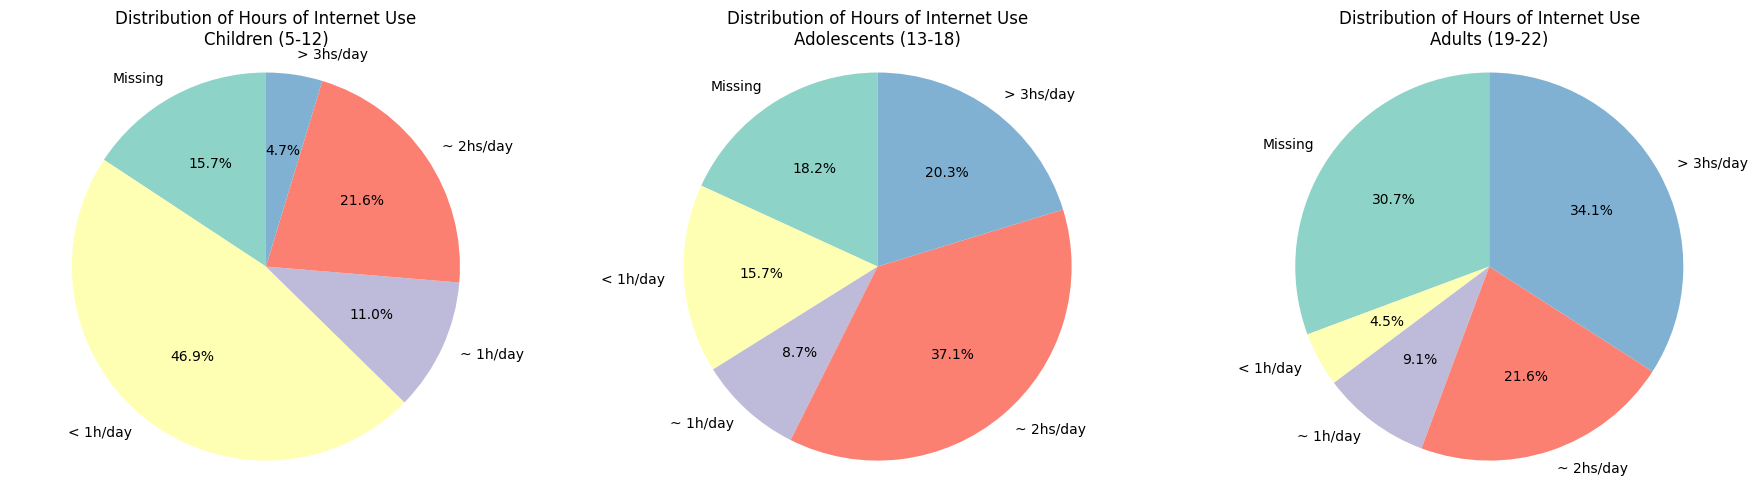

In [26]:
stats = train.groupby(
    ['Age Group', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(group_counts, labels=group_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1)
    axes[i].set_title(f'Distribution of Hours of Internet Use\n{age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

## 8. Correlation matrix

Basic_Demos-Age                           0.409559
Basic_Demos-Sex                          -0.093648
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
Physical-Diastolic_BP                     0.069321
Physical-Systolic_BP                      0.147081
Physical-HeartRate                       -0.037594
PreInt_EduHx-computerinternet_hoursday    0.374124
SDS-SDS_Total_T                           0.237718
PAQ_A-PAQ_A_Total                        -0.026854
PAQ_C-PAQ_C_Total                        -0.021943
Fitness_Endurance-Max_Stage              -0.041720
Fitness_Endurance-Time_Mins              -0.052376
Fitness_Endurance-Time_Sec               -0.000373
FGC-FGC_CU                                0.287494
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_PU                     

<Figure size 1400x3000 with 0 Axes>

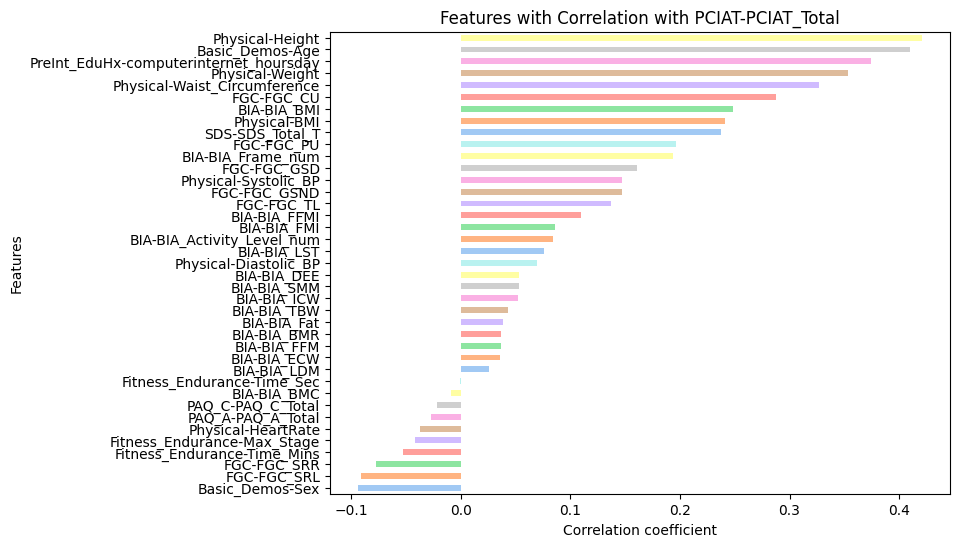

In [27]:
train_with_sii = train[train['sii'].notnull()]

plt.figure(figsize=(14, 30))
corr_matrix = train_with_sii[[
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI','BIA-BIA_FMI', 'BIA-BIA_Fat','BIA-BIA_Frame_num','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST',
    'BIA-BIA_SMM','BIA-BIA_TBW'
]].corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')

print(sii_corr)

plt.figure(figsize=(8, 6))
sii_corr.sort_values().plot(kind='barh', color=sns.color_palette("pastel", len(sii_corr)))
plt.title('Features with Correlation with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()


# III. Prepare for Train Model


## 1. Time series loading

In [28]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


## 2. Data Loading and Preprocessing

In [29]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Loads training, test, and sample submission datasets
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

# Time Series Processing
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

# Merging Data
# Merges the encoded time series features with the original training and test datasets based on 'id'.
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test  = test .drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00, 11.52it/s]


## 3. Feature Selection and Data Preparation

In [30]:
# This section selects relevant features for the training and test datasets, 
# ensuring that all necessary variables are included for further analysis or model training.

# Feature Selection
# Defines a list of feature columns to be included for model training.
# These features encompass demographic, physical, fitness, and body composition metrics, as well as derived features created during preprocessing
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']
featuresCols += time_series_cols
# Train Dataset Preparation
# Filters the training DataFrame to retain only the specified feature columns.
# Drops any rows from the training dataset where the target variable 'sii' is missing.
train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

In [31]:
def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

## 4. Evaluation Functions

In [32]:
# This section defines functions to evaluate model predictions, including handling infinite values, calculating the quadratic weighted kappa, and rounding predictions based on thresholds.

# Handling Infinite Values: Checks if any infinite values exist in the training dataset and replaces them with NaN to prevent issues during calculations.
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

# Quadratic Weighted Kappa Calculation: Computes the kappa score, which measures the level of agreement between true and predicted labels, adjusted for ordinal classifications.
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Threshold Rounding: Continuous predictions into discrete classes based on specified boundary values.
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

# Prediction Evaluation: Rounds non-rounded predictions and computes the negative quadratic weighted kappa score to assess prediction accuracy.
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

## 5. Model Training

In [33]:
# The TrainML function trains a specified machine learning model using cross-validation and generates predictions for a test dataset.
# It also optimizes the thresholds for the predictions based on a quadratic weighted kappa score.
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    # Maintain the distribution of classes across folds.
    # For each fold, the model is trained, and predictions are made on both the training and validation sets.
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        # Calculates the Quadratic Weighted Kappa score for both training and validation predictions, storing the results for later analysis.
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    # Optimizes thresholds for the predictions using the minimize function from SciPy, targeting an improved kappa score.
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

## 6. Model Parameters

In [34]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'n_estimators': 300,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01,
    'random_state': SEED,
    "verbose": -1,
    'device': 'cpu'
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  
    'reg_lambda': 5,  
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}

# CatBoost parameters
CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10, 
    'task_type': 'GPU'
}

# RF parameters
RF_Params = {
    "n_estimators": 493,
    "max_depth": 5,
    "min_samples_split": 6,
    "min_samples_leaf": 1,
    "max_features": None,
    "bootstrap": True,
    "random_state": SEED,
}

# GB parameters
GB_Params = {
    "n_estimators": 295,
    "learning_rate": 0.012,
    "max_depth": 3,
    "min_samples_split": 18,
    "min_samples_leaf": 5,
    "subsample": 0.6,
    "max_features": None,
    "random_state": SEED,
}

In [35]:
# New: TabNet
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        # Handle missing values
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values
            
        # Create internal validation set
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, 
            y, 
            test_size=0.2,
            random_state=42
        )
        
        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )
        
        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file
        
        return self
    
    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()
    
    def __deepcopy__(self, memo):
        # Add deepcopy support for scikit-learn
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

# TabNet hyperparameters
TabNet_Params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layer in each GLU block
    'n_shared': 2,          # Number of shared GLU layer in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', 
                 save_best_only=True, verbose=1):
        super().__init__()  # Initialize parent class
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer  # Use trainer itself as model
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Check if current metric is better than best
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)  # Save the entire model

# IV. First Model

In [36]:
imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(**Params))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(**XGB_Params))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(**CatBoost_Params))])),
    ('tabnet', Pipeline(steps=[('imputer', imputer), ('regressor', TabNetWrapper(**TabNet_Params))])),
])

# Train the ensemble model
Submission1 = TrainML(ensemble, test)

Submission1
print(Submission1['sii'].value_counts())

Training Folds: 100%|██████████| 5/5 [00:56<00:00, 11.36s/it]

Mean Train QWK --> 0.6413
Mean Validation QWK ---> 0.3566


----> || Optimized QWK SCORE ::  0.449
sii
1    11
0     9
Name: count, dtype: int64


# V. Second Model

In [37]:
imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(**Params))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(**XGB_Params))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(**CatBoost_Params))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(**RF_Params))])),
])

# Train the ensemble model
Submission2 = TrainML(ensemble, test)

Submission2
print(Submission2['sii'].value_counts())

Training Folds: 100%|██████████| 5/5 [01:37<00:00, 19.40s/it]

Mean Train QWK --> 0.6973
Mean Validation QWK ---> 0.3754


----> || Optimized QWK SCORE ::  0.457
sii
1    10
0     9
2     1
Name: count, dtype: int64


# VI. Third Model

In [38]:
imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(**Params))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(**XGB_Params))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(**CatBoost_Params))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(**RF_Params))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(**GB_Params))]))
])

Submission3 = TrainML(ensemble, test)

Submission3
print(Submission3['sii'].value_counts())

Training Folds: 100%|██████████| 5/5 [02:03<00:00, 24.70s/it]

Mean Train QWK --> 0.6575
Mean Validation QWK ---> 0.3708


----> || Optimized QWK SCORE ::  0.462
sii
0    10
1     9
2     1
Name: count, dtype: int64


# VII. Final submission

In [39]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(vote, axis=1)

FinalSubmission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

FinalSubmission.to_csv('submission.csv', index=False)

print(FinalSubmission['sii'].value_counts())

sii
1    10
0     9
2     1
Name: count, dtype: int64


In [40]:
FinalSubmission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,1
